# Analysis of Beam Simulator Images and Brighter-fatter Correction
<br>Owner(s): **Andrew Bradshaw** ([@andrewkbradshaw](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@andrewkbradshaw))
<br>Last Verified to Run: **2018-08-22**
<br>Verified Stack Release: **16.0 and 16.0+22 (w_2018_31)**

This notebook demonstrates the [brighter-fatter systematic error](https://arxiv.org/abs/1402.0725) on images of stars and galaxies illuminated on an ITL-3800C-002 CCD at the [UC Davis LSST beam simulator laboratory](https://arxiv.org/abs/1411.5667). Using a series of images at increasing exposure times, we demonstrate the broadening of image profiles on DM stack shape measurements, and a [possible correction method](https://arxiv.org/abs/1711.06273) which iteratively applies a kernel to restore electrons to the pixels from which they were deflected. To keep things simple, for now we skip most DM stack instrument signature removal (ISR) and work on a subset of images which are already processed arrays (500x500) of electrons.

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Characterize and measure objects (stars/galaxies) in LSST beam simulator images
2. Test the Brighter-Fatter kernel correction method on those images
3. Build your own tests of stack ISR algorithms

### Logistics
This notebook is intended to be runnable on `lsst-lspdev.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from itertools import cycle
from astropy.io import fits
import time,glob,os


# if running stack v16.0, silence a long matplotlib Agg warning with:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

# make a directory to write the catalogs
username=os.environ.get('USERNAME')
cat_dir='/home/'+username+'/DATA/beamsim/'
if not os.path.exists(cat_dir):
    ! mkdir /home/$USER/DATA/beamsim/

jld-lab-sarujin-r160
lsst_distrib          16.0+1     	current v16_0 setup


## Step 1: Read in an image
Cut-outs of beam simulator star/galaxy images have been placed in the shared data directory at `/project/shared/data/beamsim/bfcorr/`. We skip (for now) most of the instrument signature removal (ISR) steps because these are preprocessed images (bias subtracted, gain corrected). We instead start by reading in one of those `.fits` files and making an image plane `afwImage.ExposureF` as well as a variance plane (based upon the image), which is then ready for characterization and calibration in the following cells.

In [2]:
import lsst.afw.image as afwImage
from lsst.ip.isr.isrFunctions import updateVariance

# where the data lives, choosing one image to start
imnum=19 # for this dataset, choose 0-19 as an example
fitsglob='/project/shared/data/beamsim/bfcorr/*part.fits'
fitsfilename = np.sort(glob.glob(fitsglob))[imnum]  

# Read in a single image to an afwImage.ImageF object
image_array=afwImage.ImageF.readFits(fitsfilename)
image = afwImage.ImageF(image_array)
exposure = afwImage.ExposureF(image.getBBox())
exposure.setImage(image)
hdr=fits.getheader(fitsfilename) # the header has some useful info in it
print("Read in ",fitsfilename.split('/')[-1])

# Set the variance plane using the image plane via updateVariance function
gain = 1.0 # because these images are already gain corrected
readNoise = 10.0  # in electrons
updateVariance(exposure.getMaskedImage(), gain, readNoise)

# Another way of setting variance and/or masks?
#mask = afwImage.makeMaskFromArray(np.zeros((4000,4072)).astype('int32'))
#variance = afwImage.makeImageFromArray((readNoise**2 + image_array.array())
#masked_image = afwImage.MaskedImageF(image, mask, variance)
#exposure = afwImage.ExposureF(masked_image)

Read in  ITL-3800C-002_spot_spot_419_20171108115142part.fits


Now visualize the image and its electron distribution using matplotlib. Things to note: 1) the array is (purposefully) tilted with respect to the pixel grid, 2) most pixel values are at the background/sky level (a function of the mask opacity and illumination), but there is a pileup of counts around ~200k electrons indicating full well and saturation in some of the brightest pixels of the image

(Text(0.5,0,'Number of electrons in pixel'), Text(0,0.5,'Number of pixels'))

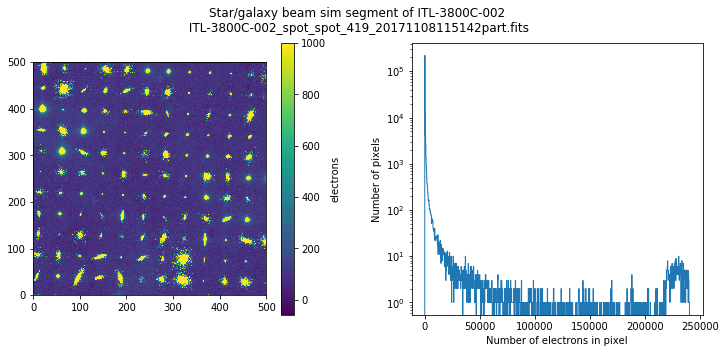

In [3]:
plt.figure(figsize=(12,5)),plt.subplots_adjust(wspace=.3)
plt.suptitle('Star/galaxy beam sim segment of '+hdr['CCD_SERN']+'\n '+fitsfilename.split('/')[-1])

plt.subplot(121)
plt.imshow(exposure.getImage().array,vmax=1e3,origin='lower')
plt.colorbar(label='electrons')

plt.subplot(122)
plt.hist(exposure.getImage().array.flatten(),bins=1000,histtype='step')
plt.yscale('log')#,plt.xscale('log')
plt.xlabel('Number of electrons in pixel'),plt.ylabel('Number of pixels')

In [4]:
# +TODO perhaps some other image stats from 
# https://github.com/lsst/pipe_tasks/blob/master/python/lsst/pipe/tasks/exampleStatsTasks.py

## Step 2: Perform image characterization and initial measurement
We now perform a base-level characterization of the image using the stack. We set some configuration settings which are specific to our sestup which has a very small optical PSF, setting a PSF size and turning off some other aspects such as cosmic ray rejection because of this.

In [5]:
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
import lsst.meas.extensions.shapeHSM

# first set a few configs that are specific to our beam simulator data
charConfig = CharacterizeImageConfig()
#this set the fwhm of the simple PSF to that of optics
charConfig.installSimplePsf.fwhm = .2
charConfig.doMeasurePsf = False
charConfig.doApCorr = False # necessary
charConfig.repair.doCosmicRay = False  
# we do have some cosmic rays, but we also have subpixel mask features and an undersampled PSF
charConfig.detection.background.binSize = 10   # worth playing around with
#charConfig.background.binSize = 50
charConfig.detection.minPixels = 2   # also worth playing around with

# Add the HSM (Hirata/Seljak/Mandelbaum) adaptive moments shape measurement plugin
charConfig.measurement.plugins.names |= ["ext_shapeHSM_HsmSourceMoments"]
# to configure hsm you would do something like
# charConfig.measurement.plugins["ext_shapeHSM_hsmSourceMoments"].addFlux = True
# (see sfm.py in meas_base for all the configuration options for the measurement task)

charTask = CharacterizeImageTask(config=charConfig)

charTask.characterize?
# use charTask.run instead of characterize for v16.0+22
# could also perform similar functions with processCcdTask.run()

Signature: charTask.characterize(exposure, exposureIdInfo=None, background=None)
Docstring:
!Characterize a science image

Peforms the following operations:
- Iterate the following config.psfIterations times, or once if config.doMeasurePsf false:
    - detect and measure sources and estimate PSF (see detectMeasureAndEstimatePsf for details)
- interpolate over cosmic rays
- perform final measurement

@param[in,out] exposure  exposure to characterize (an lsst.afw.image.ExposureF or similar).
    The following changes are made:
    - update or set psf
    - set apCorrMap
    - update detection and cosmic ray mask planes
    - subtract background and interpolate over cosmic rays
@param[in] exposureIdInfo  ID info for exposure (an lsst.obs.base.ExposureIdInfo).
    If not provided, returned SourceCatalog IDs will not be globally unique.
@param[in,out] background  initial model of background already subtracted from exposure
    (an lsst.afw.math.BackgroundList). May be None if no background 

In [6]:
# Display which plugins are being used for measurement
charConfig.measurement.plugins.active 

[lsst.meas.base.wrappers.SdssCentroidConfig(doMeasure=True, binmax=16, doFootprintCheck=True, maxDistToPeak=-1.0, peakMin=-1.0, wfac=1.5),
 lsst.meas.base.wrappers.ApertureFluxConfig(doMeasure=True, maxSincRadius=10.0, radii=[3.0, 4.5, 6.0, 9.0, 12.0, 17.0, 25.0, 35.0, 50.0, 70.0], shiftKernel='lanczos5'),
 lsst.meas.base.wrappers.SdssShapeConfig(doMeasure=True, background=0.0, doMeasurePsf=True, maxIter=100, maxShift=0.0, tol1=9.999999747378752e-06, tol2=9.999999747378752e-05),
 lsst.meas.base.wrappers.PixelFlagsConfig(doMeasure=True, masksFpAnywhere=[], masksFpCenter=[]),
 lsst.meas.base.wrappers.GaussianFluxConfig(doMeasure=True, background=0.0),
 lsst.meas.base.wrappers.HsmSourceMomentsConfig(doMeasure=True),
 lsst.meas.base.wrappers.PsfFluxConfig(doMeasure=True, badMaskPlanes=[])]

Characterization took  1.27  seconds
Detected  126  objects 


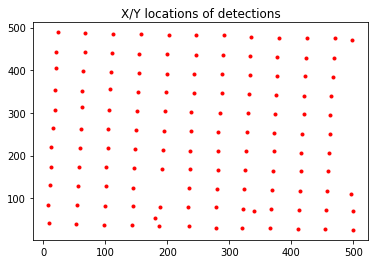

In [7]:
tstart=time.time()
charResult = charTask.characterize(exposure) # charTask.run(exposure) stack v16.0+22
print("Characterization took ",str(time.time()-tstart)[:4]," seconds")
print("Detected ",len(charResult.sourceCat)," objects ")

plt.title('X/Y locations of detections')
plt.plot(charResult.sourceCat['base_SdssCentroid_x'],charResult.sourceCat['base_SdssCentroid_y'],'r.')

In [8]:
# display some of the source catalog measurements filtered by searchword
searchword='shape'
for name in charResult.sourceCat.schema.getOrderedNames():
    if searchword in name.lower():
        print(name)

base_SdssShape_xx
base_SdssShape_yy
base_SdssShape_xy
base_SdssShape_xxSigma
base_SdssShape_yySigma
base_SdssShape_xySigma
base_SdssShape_x
base_SdssShape_y
base_SdssShape_flux
base_SdssShape_fluxSigma
base_SdssShape_psf_xx
base_SdssShape_psf_yy
base_SdssShape_psf_xy
base_SdssShape_flux_xx_Cov
base_SdssShape_flux_yy_Cov
base_SdssShape_flux_xy_Cov
base_SdssShape_flag
base_SdssShape_flag_unweightedBad
base_SdssShape_flag_unweighted
base_SdssShape_flag_shift
base_SdssShape_flag_maxIter
base_SdssShape_flag_psf
ext_shapeHSM_HsmSourceMoments_x
ext_shapeHSM_HsmSourceMoments_y
ext_shapeHSM_HsmSourceMoments_xx
ext_shapeHSM_HsmSourceMoments_yy
ext_shapeHSM_HsmSourceMoments_xy
ext_shapeHSM_HsmSourceMoments_flag
ext_shapeHSM_HsmSourceMoments_flag_no_pixels
ext_shapeHSM_HsmSourceMoments_flag_not_contained
ext_shapeHSM_HsmSourceMoments_flag_parent_source


Unique mask plane values:  [ 0 32]
Mask dictionary entries:  {'BAD': 0, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7}


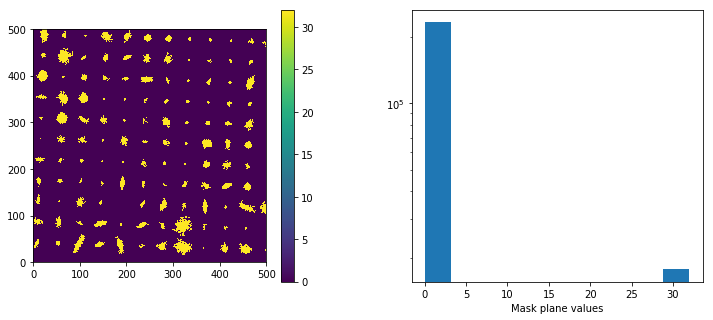

In [9]:
# Looking at the mask plane, which started off as all zeros
# and now has some values of 2^5
maskfoo=exposure.getMask()
print("Unique mask plane values: ",np.unique(maskfoo.array))
print("Mask dictionary entries: ",maskfoo.getMaskPlaneDict())

plt.figure(figsize=(12,5)),plt.subplots_adjust(wspace=.3)
plt.subplot(121)
plt.imshow(maskfoo.array,origin='lower'),plt.colorbar()
plt.subplot(122)
plt.hist(maskfoo.array.flatten()),plt.xlabel('Mask plane values')
plt.yscale('log')

## Step 3: Further image calibration and measurement
This builds on the exposure output from characterization, using the new mask plane as well as the source catalog. Similarly to the characterization, we turn off some processing which is suited to our particular setup.

In [10]:
from lsst.pipe.tasks.calibrate import CalibrateTask, CalibrateConfig

calConfig = CalibrateConfig()
calConfig.doAstrometry = False
calConfig.doPhotoCal = False
calConfig.doApCorr = False
calConfig.doDeblend = False   # these are well-separated objects, deblending adds time & trouble
# these images should have a uniform background, so measure it
#  on scales which are larger than the objects
calConfig.detection.background.binSize = 50
calConfig.detection.minPixels = 15
calConfig.measurement.plugins.names |= ["ext_shapeHSM_HsmSourceMoments"]
# to configure hsm you would do something like
#charConfig.measurement.plugins["ext_shapeHSM_hsmSourceMoments"].addFlux = True

calTask = CalibrateTask(config= calConfig, icSourceSchema=charResult.sourceCat.schema)

#calTask.run? # for stack v16.0+22 
calTask.calibrate?

Signature: calTask.calibrate(exposure, exposureIdInfo=None, background=None, icSourceCat=None)
Docstring:
!Calibrate an exposure (science image or coadd)

@param[in,out] exposure  exposure to calibrate (an
    lsst.afw.image.ExposureF or similar);
    in:
    - MaskedImage
    - Psf
    out:
    - MaskedImage has background subtracted
    - Wcs is replaced
    - Calib zero-point is set
@param[in] exposureIdInfo  ID info for exposure (an
    lsst.obs.base.ExposureIdInfo) If not provided, returned
    SourceCatalog IDs will not be globally unique.
@param[in,out] background  background model already subtracted from
    exposure (an lsst.afw.math.BackgroundList). May be None if no
    background has been subtracted, though that is unusual for
    calibration. A refined background model is output.
@param[in] icSourceCat  A SourceCatalog from CharacterizeImageTask
    from which we can copy some fields.

@return pipe_base Struct containing these fields:
- exposure  calibrate science exposure

In [11]:
tstart=time.time()
# for stack v16.0+22, change to calTask.run(charResult.exposure)
calResult = calTask.calibrate(charResult.exposure, background=charResult.background,
                              icSourceCat = charResult.sourceCat)

print("Calibration took ",str(time.time()-tstart)[:4]," seconds")
print("Detected ",len(calResult.sourceCat)," objects ")

Calibration took  1.00  seconds
Detected  137  objects 


Below we look at some of the measurements in the source catalog which has been attached to the calibration result. We also save the source catalog to `$fitsfilename.cat` in `/home/$USER/beamsim/`, which was created in the first cell. This will allow the results from each image to be read in after these measurements are performed on each image.

In [12]:
cat_dir

'/home/sarujin/DATA/beamsim/'

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


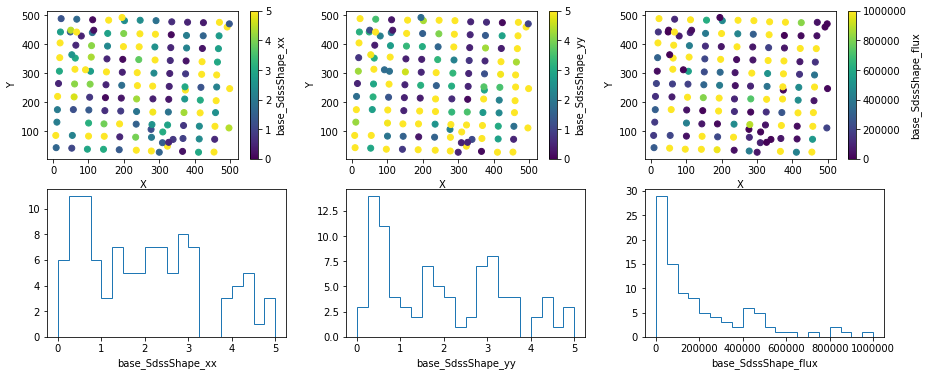

In [13]:
src=calResult.sourceCat  #.copy(deep=True) ?
#print(src.asAstropy)

# catalog directory
src.writeFits(cat_dir+fitsfilename.split('/')[-1].replace('.fits','.cat'))
# read back in and access via:
#catalog=fits.open(fitsfilename+'.cat')
#catalog[1].data['base_SdssShape_xx'] etc.

par_names=['base_SdssShape_xx','base_SdssShape_yy','base_SdssShape_flux']
par_mins=[0,0,0]
par_maxs=[5,5,1e6]
n_par=len(par_names)


plt.figure(figsize=(5*n_par,6)),plt.subplots_adjust(wspace=.25)
for par_name,par_min,par_max,i in zip(par_names,par_mins,par_maxs,range(n_par)):
    plt.subplot(2,n_par,i+1)
    plt.scatter(src['base_SdssCentroid_x'],src['base_SdssCentroid_y'],c=src[par_name],marker='o',vmin=par_min,vmax=par_max)
    plt.xlabel('X'),plt.ylabel('Y'),plt.colorbar(label=par_name)


    plt.subplot(2,n_par,n_par+i+1)
    plt.hist(src[par_name],range=[par_min,par_max],bins=20,histtype='step')
    plt.xlabel(par_name)

### Optional step: Display the image with Firefly and overlay detected objects
This is a nice interface for looking at measurements and images together, and it is much more powerful than demonstrated below (see other stack club notebooks for demonstration). From this display, it is clear that some objects are detected as two or more, complicating downstream measurements.

In [14]:
import lsst.afw.display as afwDisplay

# Firefly client imports
from firefly_client import FireflyClient

# Standard libraries in support of Firefly display
from urllib.parse import urlparse, urlunparse, ParseResult
from IPython.display import IFrame, display, Markdown
import os

# Own cell?
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'

# This needs its own cell
ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,1000,600)



In [15]:
# set the backend and attach to the waiting display channel
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

# Open the exposure (Firefly knows about mask planes)
afw_display.mtv(exposure)

# Now overplot sources from the src table onto the image display using the Display’s dot method 
# It is more efficient to send a batch of updates to the display, 
# so we enclose the loop in a display.Buffering context, like this:

afw_display.erase()   #

with afw_display.Buffering():
    for record in src[:]:
        afw_display.dot('o', record.getX(), record.getY(), size=20, ctype='orange')

## Step 4: Apply the brighter-fatter kernel correction to an image
This brighter fatter correction method takes in a "kernel" (derived from theory or flat fields) which models the broadening of incident image profiles assuming the pixel boundary displacement can be represented as the gradient of a scalar field. Given a kernel and this assumption, the incident image profile can in theory be reconstructed using an iterative process, which we test here using our beam simulator images. See [this paper](https://arxiv.org/abs/1711.06273) and the IsrTask docstring below for more details about the theory and its assumptions.

In [16]:
from lsst.ip.isr.isrTask import IsrTask # brighterFatterCorrection lives here
isr=IsrTask()

pre_bfcorr_exposure=exposure.clone() #save a copy of the pre-bf corrected image

isr.brighterFatterCorrection?

Signature: isr.brighterFatterCorrection(exposure, kernel, maxIter, threshold, applyGain)
Docstring:
Apply brighter fatter correction in place for the image

This correction takes a kernel that has been derived from flat field images to
redistribute the charge.  The gradient of the kernel is the deflection
field due to the accumulated charge.

Given the original image I(x) and the kernel K(x) we can compute the corrected image  Ic(x)
using the following equation:

Ic(x) = I(x) + 0.5*d/dx(I(x)*d/dx(int( dy*K(x-y)*I(y))))

To evaluate the derivative term we expand it as follows:

0.5 * ( d/dx(I(x))*d/dx(int(dy*K(x-y)*I(y))) + I(x)*d^2/dx^2(int(dy* K(x-y)*I(y))) )

Because we use the measured counts instead of the incident counts we apply the correction
iteratively to reconstruct the original counts and the correction.  We stop iterating when the
summed difference between the current corrected image and the one from the previous iteration
is below the threshold.  We do not require converge

Brighter-fatter correction took 3.471991777420044  seconds
-0.72  percent change in flux


Text(0.5,0,'Pixel values [e-]')

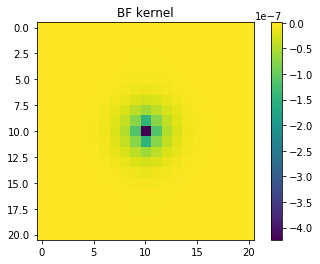

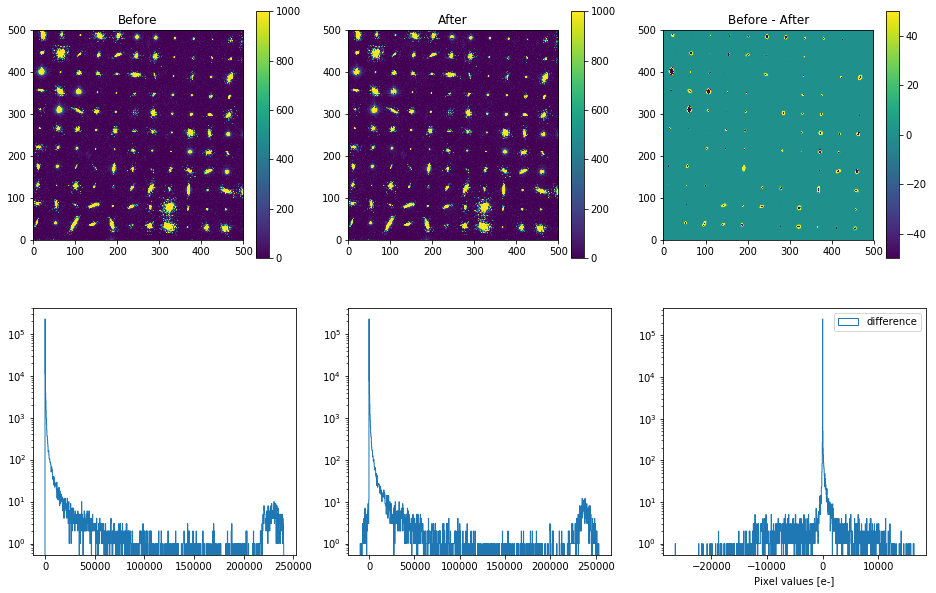

In [17]:
# Read in the kernel (determined from e.g. simulations or flat fields)
kernel=fits.getdata('/project/shared/data/beamsim/bfcorr/BF_kernel-ITL_3800C_002.fits')
exposure=pre_bfcorr_exposure.clone() # save the pre-bf correction image

# define the maximum number of iterations and threshold for differencing convergence (e-)
bf_maxiter,bf_threshold=20,10

# Perform the correction
tstart=time.time()
isr.brighterFatterCorrection(exposure,kernel,bf_maxiter,bf_threshold,False)
print("Brighter-fatter correction took",time.time()-tstart," seconds")
#takes 99 seconds for 4kx4k exposure, 21x21 kernel, 20 iterations, 10 thresh

# Plot kernel and image differences
plt.figure(),plt.title('BF kernel')
plt.imshow(kernel),plt.colorbar()

imagediff=(pre_bfcorr_exposure.getImage().array-exposure.getImage().array)
imagediffpct=np.sum(imagediff)/np.sum(pre_bfcorr_exposure.getImage().array)*100.
print(str(imagediffpct)[:5],' percent change in flux')

plt.figure(figsize=(16,10))
plt.subplot(231),plt.title('Before')
plt.imshow(pre_bfcorr_exposure.getImage().array,vmin=0,vmax=1e3,origin='lower'),plt.colorbar()
plt.subplot(232),plt.title('After')
plt.imshow(exposure.getImage().array,vmin=0,vmax=1e3,origin='lower'),plt.colorbar()
plt.subplot(233),plt.title('Before - After')
vmin,vmax=-50,50
plt.imshow(imagediff,vmin=vmin,vmax=vmax,origin='lower'),plt.colorbar()

nbins=1000
plt.subplot(234)
plt.hist(pre_bfcorr_exposure.getImage().array.flatten(),bins=nbins,histtype='step',label='before')
plt.yscale('log')
plt.subplot(235)
plt.hist(exposure.getImage().array.flatten(),bins=nbins,histtype='step',label='after')
plt.yscale('log')
plt.subplot(236)
plt.hist(imagediff.flatten(),bins=nbins,histtype='step',label='difference')
plt.yscale('log')
plt.legend()
plt.xlabel('Pixel values [e-]')


### Step 5: Run the above steps (with and without brighter-fatter correction) on the 20 exposures of increasing brightness
Making and saving catalogs should take (with do_bf_corr=True/False) around 1 & 5 seconds per image.

In [18]:
do_bf_corr=True  # True or False, run this cell with both
fitsglob='/project/shared/data/beamsim/bfcorr/*part.fits'  # fits files to read in

for fitsfilename in np.sort(glob.glob(fitsglob)):
    image_array=afwImage.ImageF.readFits(fitsfilename)
    image = afwImage.ImageF(image_array)

    exposure = afwImage.ExposureF(image.getBBox())
    exposure.setImage(image)

    updateVariance(exposure.getMaskedImage(), gain, readNoise)
    
    # start the characterization and measurement, optionally beginning with the brighter-fatter correction
    tstart=time.time()
    if do_bf_corr:
        isr.brighterFatterCorrection(exposure,kernel,bf_maxiter,bf_threshold,False)
        # print("Brighter-fatter correction took",str(time.time()-tstart)[:4]," seconds")
    # for stack v16.0+22 use charTask.run() and calTask.run()
    charResult = charTask.characterize(exposure)  
    calResult = calTask.calibrate(charResult.exposure, background=charResult.background,
                                  icSourceCat = charResult.sourceCat)
    src=calResult.sourceCat  #.copy(deep=True) ?
    
    # write out the source catalog, appending -bfcorr for the corrected catalogs
    catfilename=cat_dir+fitsfilename.replace('.fits','.cat').split('/')[-1]#
    if do_bf_corr: catfilename=catfilename.replace('.cat','-bfcorr.cat')
    src.writeFits(catfilename)
    
    print(fitsfilename.split('/')[-1]," char. & calib. took ",str(time.time()-tstart)[:4]," seconds to measure ",len(calResult.sourceCat)," objects ")



ITL-3800C-002_spot_spot_400_20171108114719part.fits  char. & calib. took  2.47  seconds to measure  73  objects 
ITL-3800C-002_spot_spot_401_20171108114728part.fits  char. & calib. took  2.93  seconds to measure  85  objects 
ITL-3800C-002_spot_spot_402_20171108114738part.fits  char. & calib. took  3.48  seconds to measure  97  objects 
ITL-3800C-002_spot_spot_403_20171108114749part.fits  char. & calib. took  3.54  seconds to measure  102  objects 
ITL-3800C-002_spot_spot_404_20171108114800part.fits  char. & calib. took  3.91  seconds to measure  106  objects 
ITL-3800C-002_spot_spot_405_20171108114811part.fits  char. & calib. took  3.99  seconds to measure  112  objects 
ITL-3800C-002_spot_spot_406_20171108114823part.fits  char. & calib. took  4.39  seconds to measure  115  objects 
ITL-3800C-002_spot_spot_407_20171108114835part.fits  char. & calib. took  4.43  seconds to measure  118  objects 
ITL-3800C-002_spot_spot_408_20171108114848part.fits  char. & calib. took  4.79  seconds to 

Now read in those catalogs, both corrected and uncorrected (this could be improved with e.g. pandas)

In [19]:
cat_arr = []
catglob=cat_dir+'ITL*part.cat' # uncorrected catalogs
for catfilename in np.sort(glob.glob(catglob)): cat_arr.append(fits.getdata(catfilename))

bf_cat_arr = []
catglob=cat_dir+'ITL*part-bfcorr.cat' # corrected catalogs
for catfilename in np.sort(glob.glob(catglob)): bf_cat_arr.append(fits.getdata(catfilename))
ncats=len(cat_arr)

Text(0.5,1,'Centroids of sequential exposures')

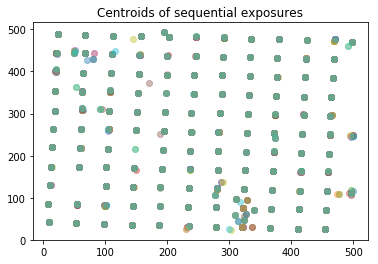

In [20]:
# Show issues with multiply detected sources which which we remedy with matching rejection
for i in range(ncats):
    xfoo,yfoo=cat_arr[i]['base_SdssCentroid_x'],cat_arr[i]['base_SdssCentroid_y']
    plt.plot(xfoo,yfoo,'o',alpha=.4)
plt.title('Centroids of sequential exposures')

Using a fiducial frame as reference, we simply match the catalogs by looking for *single* object matches within a specified distance. We then collect a shape measurement (e.g. `base_SdssShape_xx/yy`) for that object as well as a brightness measurement (e.g. `base_SdssShape_flux`) to test for a trend in size vs. brightness.

In [21]:
fidframe=10 # frame number to compare to
maxdist=.5  # max distance to match objects between frames

# choose which stack measurements to use for centroids and shape
# +TODO use 'ext_shapeHSM_HsmSourceMoments_xx','ext_shapeHSM_HsmSourceMoments_yy'
cen_param1,cen_param2='base_SdssCentroid_x','base_SdssCentroid_y'
bf_param1,bf_param2='base_SdssShape_xx','base_SdssShape_yy'
flux_param='base_SdssShape_flux'

# get the centroids (used for matching) from the fiducial frame 
x0s,y0s=cat_arr[fidframe][cen_param1],cat_arr[fidframe][cen_param2]
nspots=len(x0s)

# make an array to hold that number of objects and their centroid/shape/flux measurements
# the 8 rows collect x/y centroid, x/y shape, x/y corrected shape, flux, and corrected flux
bf_dat=np.empty((ncats,nspots,8))
bf_dat[:]=np.nan   # so that un-matched objects aren't plotted/used by default


# loop over catalogs
for i in range(ncats):
    # get the centroids of objects in the bf-corrected and uncorrected images
    x1,y1=cat_arr[i][cen_param1],cat_arr[i][cen_param2]
    x1_bf,y1_bf=bf_cat_arr[i][cen_param1],bf_cat_arr[i][cen_param2]
    # loop over fiducial frame centroids to find matches
    for j in range(nspots):   
        x0,y0=x0s[j],y0s[j] # fiducial centroid to match
        # find objects in both catalogs which are within maxdist
        bf_gd=np.where(np.sqrt((x1_bf-x0)**2+(y1_bf-y0)**2)<maxdist)[0]
        gd=np.where(np.sqrt((x1-x0)**2+(y1-y0)**2)<maxdist)[0]
        if (len(bf_gd)==1 & len(gd)==1):  # only take single matches
            xx,yy=cat_arr[i][bf_param1][gd],cat_arr[i][bf_param2][gd] # centroids
            xx_bf,yy_bf=bf_cat_arr[i][bf_param1][bf_gd],bf_cat_arr[i][bf_param2][bf_gd]  # sizes
            flux,flux_bf=cat_arr[i][flux_param][gd],bf_cat_arr[i][flux_param][bf_gd] # fluxes
            bf_dat[i,j,:]=x0,y0,xx,yy,xx_bf,yy_bf,flux,flux_bf  # keep those above measurements

# Plot the brighter-fatter effect on those shape measurements and the corrected version
Alongside stamps of each object, below we show the trend of X and Y sizes before and after brighter-fatter correction

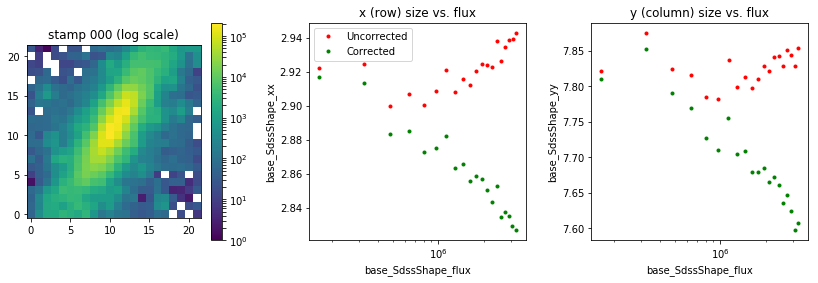

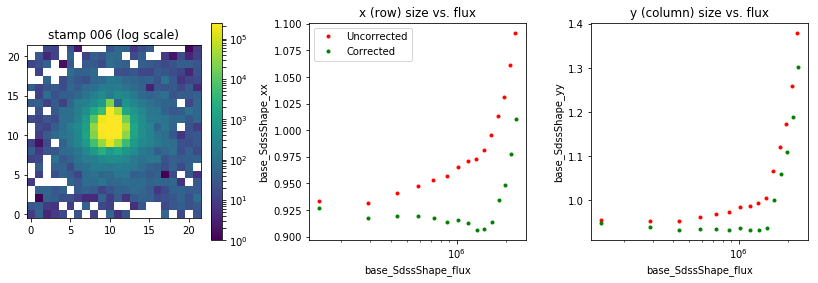

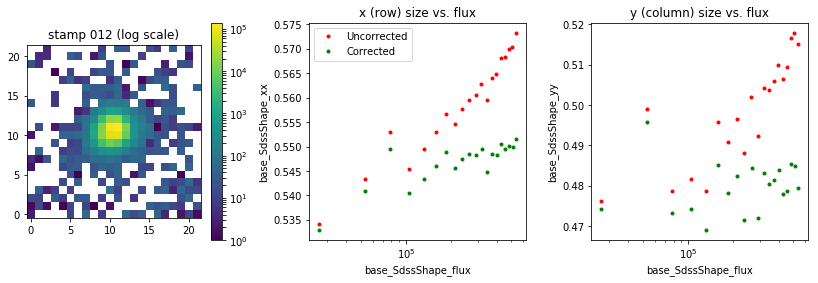

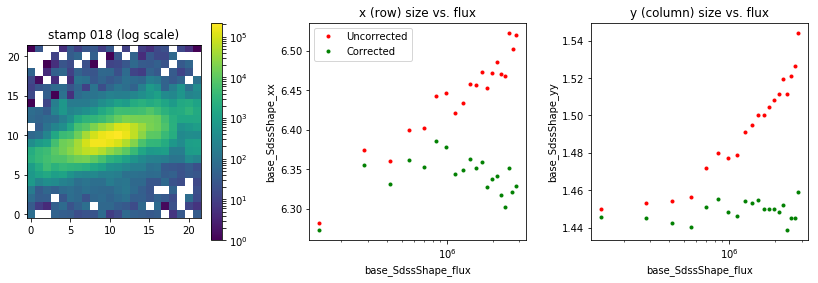

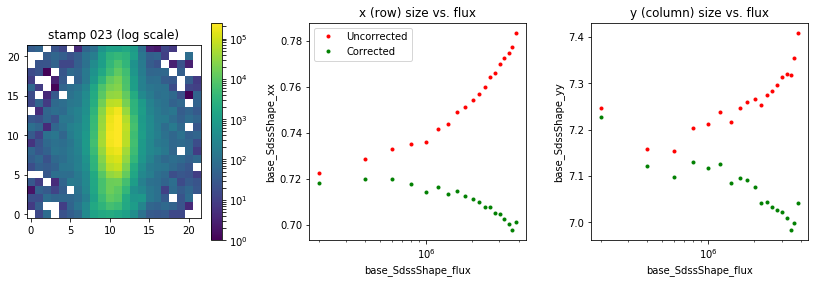

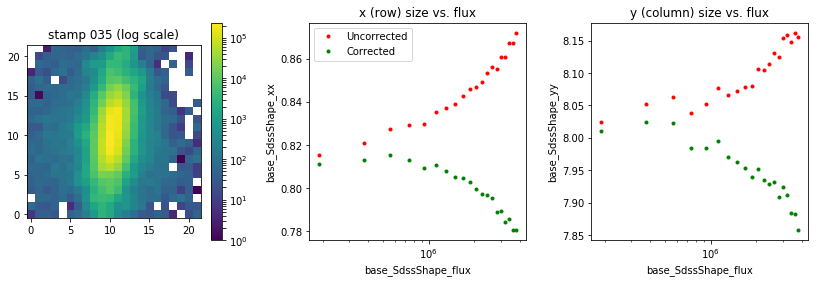

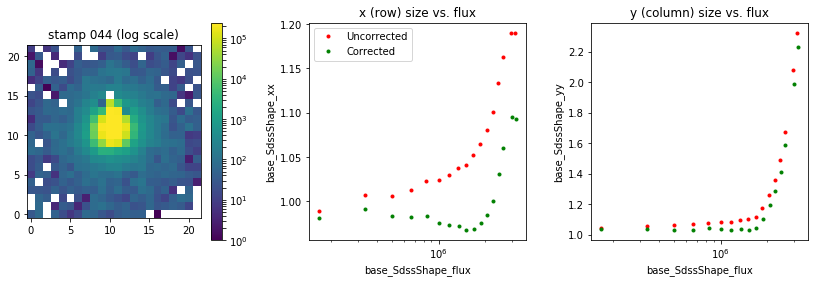

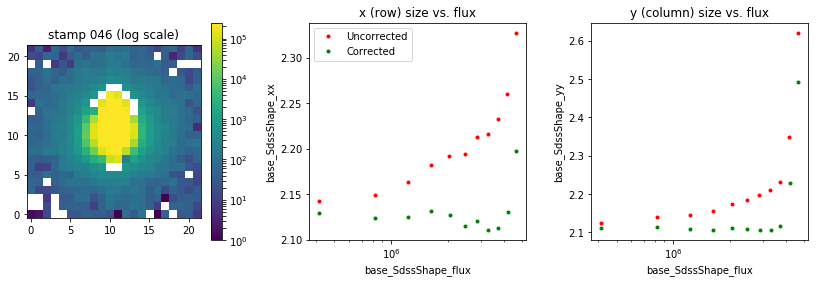

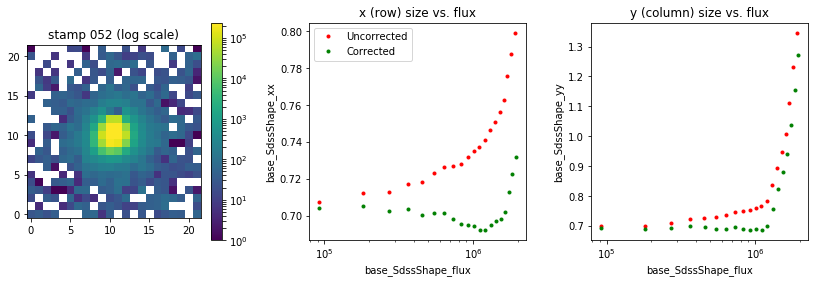

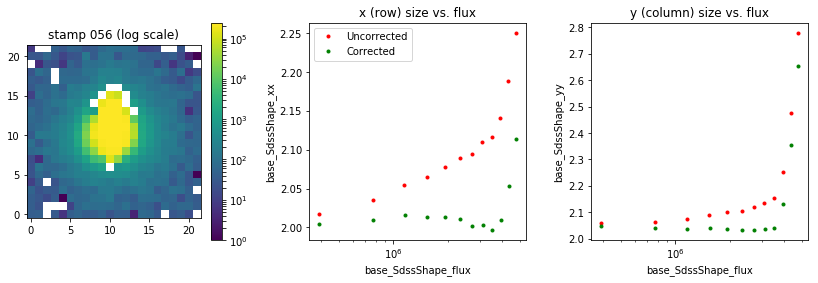

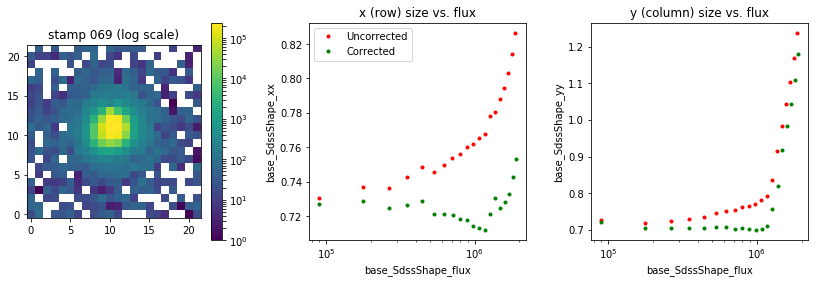

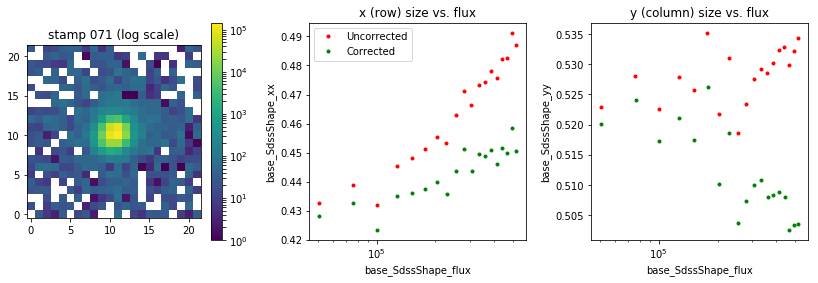

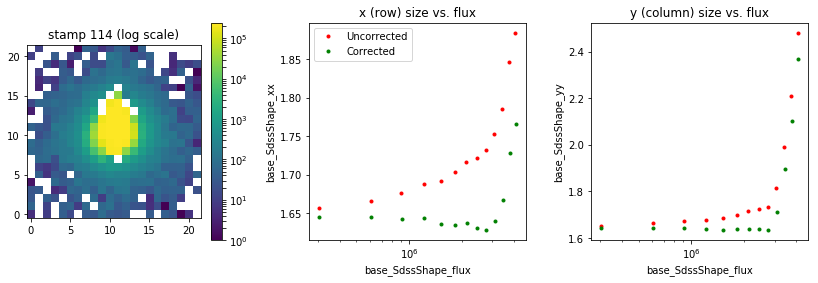

In [22]:
sz=11 # stamp size

# loop over some objects and save a summary figure
# [0,6,12,18,23,35,44,46,52,56,69,71,114] are good indices to look with default values 
# or e.g. np.random.choice(np.arange(nspots),size=10)
indexfoo=[0,6,12,18,23,35,44,46,52,56,69,71,114]

for nfoo in indexfoo:
    plt.figure(figsize=(14,4)),plt.subplots_adjust(wspace=.3)
    
    # grab a postage stamp, integerizing the centroid and shipping
    # if it is near the edge, +TODO in a stackly manner
    xc,yc=bf_dat[10,nfoo,0].astype('int')+1,bf_dat[10,nfoo,1].astype('int')+1
    if ((np.abs(xc-250)>250 - sz ) | (np.abs(yc-250)>250 - sz )): continue
    stamp=exposure.getImage().array[yc-sz:yc+sz,xc-sz:xc+sz]
    
    # show the stamp with log scale (1,max)
    plt.subplot(131),plt.title('stamp '+str(nfoo).zfill(3)+' (log scale)')
    plt.imshow(stamp,origin='lower',norm=LogNorm(1,stamp.max())),plt.colorbar()
    
    # x size vs flux
    plt.subplot(132),plt.title('x (row) size vs. flux')
    plt.plot(bf_dat[:,nfoo,6],bf_dat[:,nfoo,2],'r.',label='Uncorrected')
    plt.plot(bf_dat[:,nfoo,7],bf_dat[:,nfoo,4],'g.',label='Corrected')
    plt.xlabel(flux_param),plt.ylabel(bf_param1),plt.xscale('log')
    plt.legend(loc='upper left')

    # y size vs flux
    plt.subplot(133),plt.title('y (column) size vs. flux')
    plt.plot(bf_dat[:,nfoo,6],bf_dat[:,nfoo,3],'r.',label='Uncorrected')
    plt.plot(bf_dat[:,nfoo,7],bf_dat[:,nfoo,5],'g.',label='Corrected')
    plt.xlabel(flux_param),plt.ylabel(bf_param2)
    plt.xscale('log')
    plt.savefig(cat_dir+str(nfoo).zfill(5)+'bfcorr.png')

Now plot the flux lost/gained in the process of brighter-fatter correction

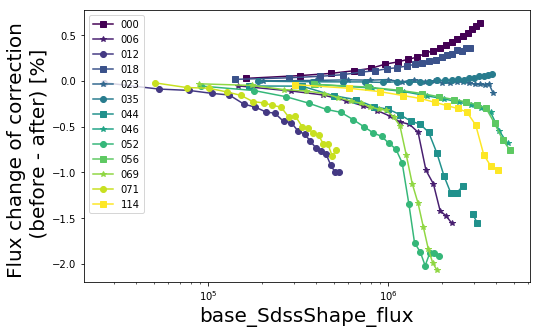

In [23]:
colorpalette=cycle(plt.cm.viridis(np.linspace(0,1,len(indexfoo))))
stylepalette=cycle(['s','*','o'])
plt.figure(figsize=(8,5))
for nfoo in indexfoo:
    flux_foo=bf_dat[:,nfoo,6]
    fluxdiffpct_foo=(bf_dat[:,nfoo,6]-bf_dat[:,nfoo,7])/bf_dat[:,nfoo,6]*100.
    plt.plot(flux_foo,fluxdiffpct_foo,label=str(nfoo).zfill(3),c=next(colorpalette),marker=next(stylepalette))
plt.xscale('log')
plt.legend()
plt.xlabel(flux_param,fontsize=20)
plt.ylabel('Flux change of correction \n (before - after) [%]',fontsize=20)
plt.savefig(cat_dir+'BF_corr_flux_change.png',dpi=150)

In [24]:
# +TODO add re-scaled stamp subtraction comparison
# +TODO other ways of doing matching, catalog stacking